<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/feature_engineering/1.data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

# Import module files

In [3]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}


files = [
    'path_manager.py',
    'sklearn_utils.py',
    'sklearn_transformers.py'
]

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/main/'
url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [4]:
import importlib
import path_manager
import sklearn_transformers
import sklearn_utils

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils,
        sklearn_transformers
    ]
)

from path_manager import PathManager

from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import nan_statistics
from sklearn_utils import visualize_datasets_distributions

from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer

# Set up paths

In [5]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'


PREPROC_TRIAL = 4
MODELS_TRIAL = 2
COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'

Mounted at /content/gdrive


In [6]:
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

In [7]:
manager.setup_paths()

/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Data/preproc_trial_4 already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_2 already exists


# 1. Frame the problem

- **Type of task?**
    - Supervised / Unsupervised / Reinforcement?
        - Supervised
    - Classification / Regression / Clustering / Novelty search?
        - Regression (univariate, multiple regression)
    - Batch learning / Online learning?
        - Batch learning

- **How company will benefit from task?**
    - **Predicting revenue (money) of a restaurang, to justify investment in building a new one in a given area**

- **Algorithms?**
    - SGD regressor, SVM, Random forest, FFNN, KNN regressor

- **Performance measure?**
    - RMSE
    - MAE if many outliers

- **What the current solution looks like?**
    - Human analysis



# 2. Check assumptions

- No serious assumptions. This competition needs indeed a regression output (values), but not categories or classes.

# 3. Download the data

In [185]:
train_df = pd.read_csv(manager.train_path, index_col='Id')
test_df = pd.read_csv(manager.test_path, index_col='Id')

In [186]:
train_df.head(1)
print(train_df.shape, test_df.shape)

(137, 42) (100000, 41)


# 4. Quick look at data structure

- Outliers and skew in the target variable (revenue)
- Approximately same range of numerical features
- No missing values

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 0 to 136
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open Date   137 non-null    object 
 1   City        137 non-null    object 
 2   City Group  137 non-null    object 
 3   Type        137 non-null    object 
 4   P1          137 non-null    int64  
 5   P2          137 non-null    float64
 6   P3          137 non-null    float64
 7   P4          137 non-null    float64
 8   P5          137 non-null    int64  
 9   P6          137 non-null    int64  
 10  P7          137 non-null    int64  
 11  P8          137 non-null    int64  
 12  P9          137 non-null    int64  
 13  P10         137 non-null    int64  
 14  P11         137 non-null    int64  
 15  P12         137 non-null    int64  
 16  P13         137 non-null    float64
 17  P14         137 non-null    int64  
 18  P15         137 non-null    int64  
 19  P16         137 non-null    i

In [ ]:
train_df.describe()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02
mean,4.014599,4.408759,4.317518,4.372263,2.007299,3.357664,5.423358,5.153285,5.445255,5.489051,...,3.135036,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788,4.453533e+06
std,2.910391,1.514900,1.032337,1.016462,1.209620,2.134235,2.296809,1.858567,1.834793,1.847561,...,1.680887,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768,2.576072e+06
min,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06
25%,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,5.000000,...,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06
50%,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,5.000000,5.000000,5.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06
75%,4.000000,5.000000,5.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,5.000000,...,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.166635e+06
max,12.000000,7.500000,7.500000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,7.500000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000,1.969694e+07


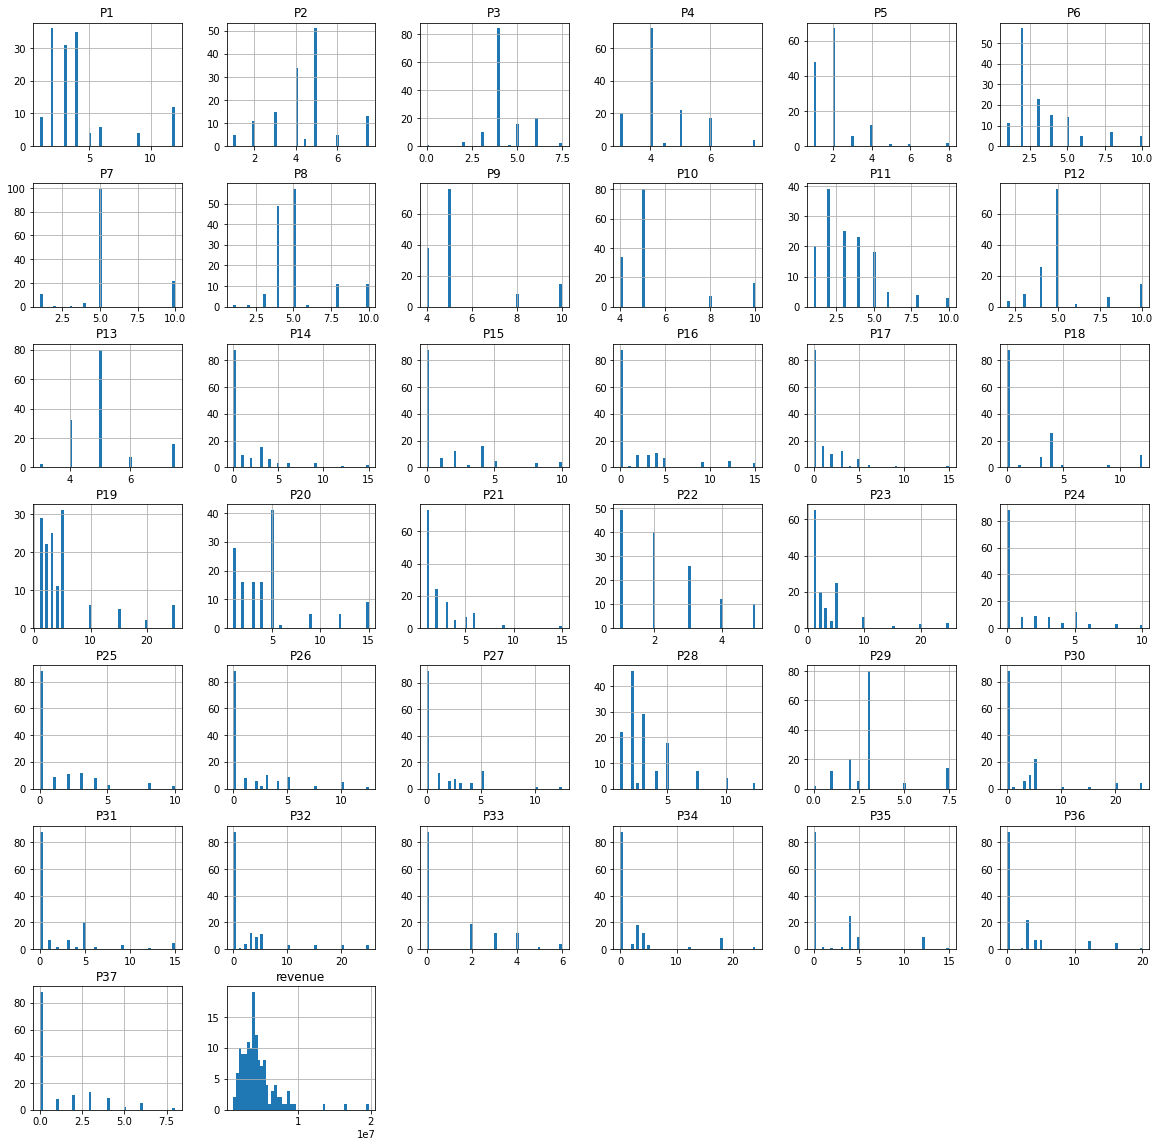

In [ ]:
_ = train_df.hist(bins=50, figsize = (20, 20))

# 5. Create test + trainval sets (remember stratified sampling)

In [187]:
TEST_PERCENTAGE = 0.15
RANDOM_STATE = 42

train_val_sample, test_sample = train_test_split(
    train_df,
    test_size = TEST_PERCENTAGE,
    random_state = RANDOM_STATE,
    # stratify = train_df['revenue'].values
)

Text(0, 0.5, 'Percentage')

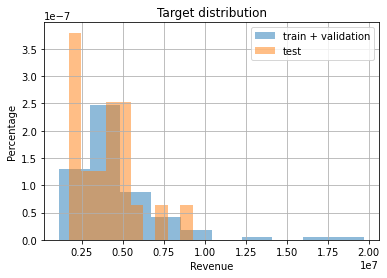

In [188]:
fig, ax = plt.subplots()

ax.hist(train_val_sample['revenue'], density=True, alpha=0.5)
ax.hist(test_sample['revenue'], density=True, alpha=0.5)

ax.legend(['train + validation', 'test'])
ax.grid()
ax.set_title('Target distribution')
ax.set_xlabel('Revenue')
ax.set_ylabel('Percentage')

# 6. Data exploration (from now on: work with trainval set)

- Heavy tail - might log-transform the data. Because many algorithms fail to detect patterns for data with heavy tails
- P28, P6, P17 - log transform
- Big cities contribute to larger revenue (City Group feature). Apply cat encoding, to enforce order
- One hot encoding for the restaurant type. We will not inflate the the dataset, as there are only 4 types of categories
- The majority of restaurants opened after 2007 (skewed). There is an upward trend - the later a restaurant is opened, the more revenue it gives. Replace text feature "Opening date" with numeric feature - year of opening
- Strong correlation with a new feature - population of the city

## Sample an exploration set

- Not necessary, dataset is of low size
- **At this step - make a copy of dataset for experiments (for safety)**

In [12]:
exploration_df = train_val_sample.copy()

## Visualizations

### Target variable

(None, None)

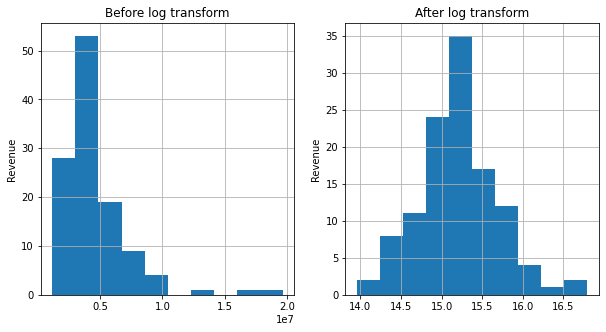

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].hist(exploration_df['revenue'])
ax[0].set_title('Before log transform')
ax[0].set_ylabel('Revenue')

ax[1].hist(np.log(exploration_df['revenue']))
ax[1].set_title('After log transform')
ax[1].set_ylabel('Revenue')

ax[0].grid(), ax[1].grid()

### Revenue by city

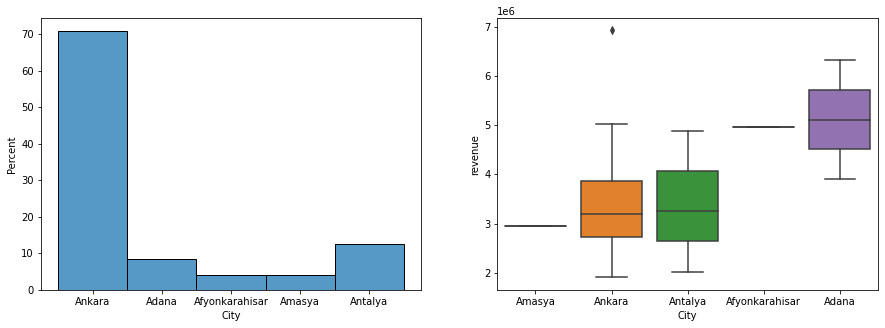

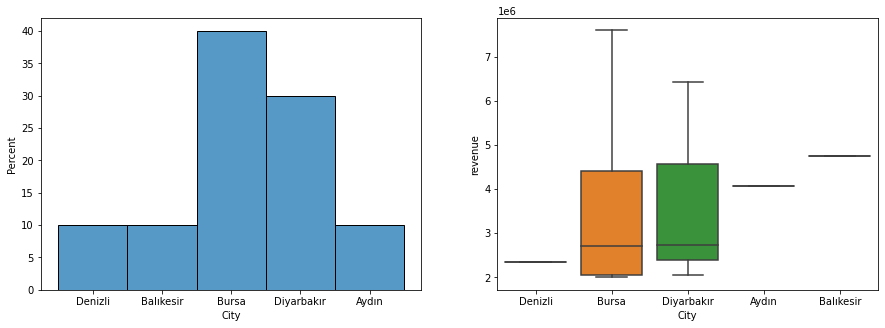

In [ ]:
counter = 0
available_cities = np.unique(exploration_df['City'])

boxplot_regression(
    df_=exploration_df.loc[np.isin(exploration_df['City'], available_cities[0:5]), :],
    cat_feature_='City',
    target_feature_='revenue'
)

boxplot_regression(
    df_=exploration_df.loc[np.isin(exploration_df['City'], available_cities[5:10]), :],
    cat_feature_='City',
    target_feature_='revenue'
)

### Restaurant type

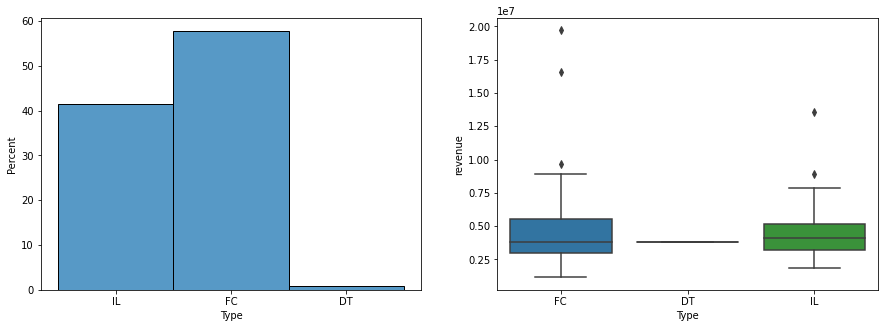

In [ ]:
exploration_df['Type'].value_counts()
boxplot_regression(
    df_=exploration_df, 
    cat_feature_='Type', 
    target_feature_='revenue'
)

### City type

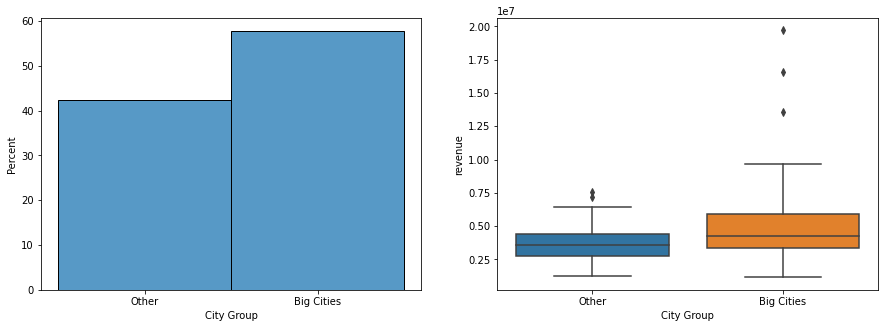

In [ ]:
boxplot_regression(exploration_df, 'City Group', 'revenue')

## Correlations & scatter matrix

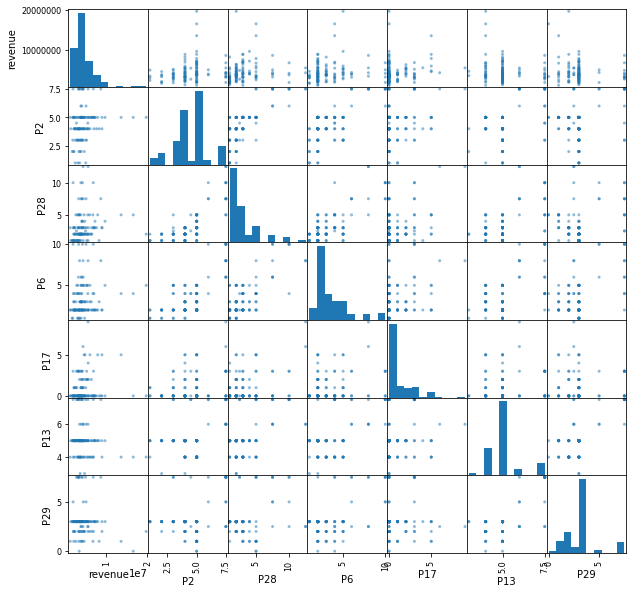

In [ ]:
attributes = get_correlated_attributes(exploration_df, 'revenue', 0.12).index
_ = scatter_matrix(exploration_df[attributes], figsize=(10, 10))

## Looking for interesting features

### Experiment with attribute combinations

- Not a lot of attributes to combine (unline Housing prices tasks, here we cannot combint P-features). I focus on feature engineering component

### Year of opening

In [ ]:
dates = exploration_df['Open Date'].values
years = [int(date.split('/')[-1]) for date in dates]
years[:5]

[2009, 2007, 2008, 2009, 2007]

In [ ]:
exploration_df['open_year'] = years

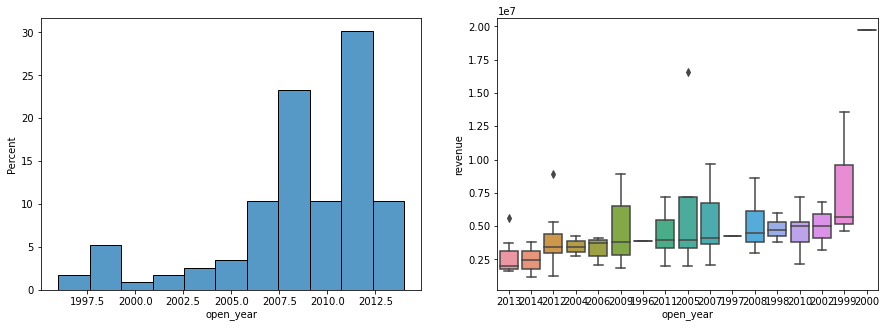

In [ ]:
boxplot_regression(exploration_df, 'open_year', 'revenue')

### How long restaurant is opened

In [ ]:
exploration_df['Open Date']

Id
4      05/09/2009
109    08/25/2007
36     05/09/2008
89     05/11/2009
100    09/21/2007
          ...    
71     12/06/2006
106    06/15/2008
14     12/29/2011
92     11/01/2002
102    09/11/2004
Name: Open Date, Length: 116, dtype: object

In [ ]:
exploration_df['Open Date dtm'] = pd.to_datetime(
    exploration_df['Open Date'],
    format='%m/%d/%Y'
)

In [ ]:
exploration_df['Open Date dtm'].dt.year + exploration_df['Open Date dtm'].dt.month 

Id
4      2014
109    2015
36     2013
89     2014
100    2016
       ... 
71     2018
106    2014
14     2023
92     2013
102    2013
Name: Open Date dtm, Length: 116, dtype: int64

In [ ]:
exploration_df['BusinessPeriod'] = \
    (exploration_df['Open Date dtm'].max()
     - exploration_df['Open Date dtm']).dt.days

pep8(_ih)

revenue           1.000000
BusinessPeriod    0.320551
P2                0.191189
P28               0.150818
P6                0.136381
P17               0.133384
P22               0.099139
P21               0.094685
P13              -0.126957
P29              -0.127254
open_year        -0.318152
Name: revenue, dtype: float64

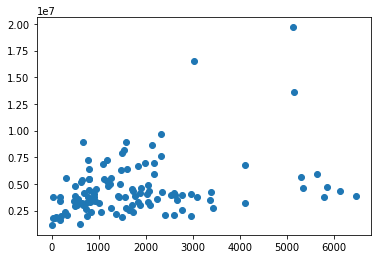

In [ ]:
plt.scatter(
    x=exploration_df['BusinessPeriod'],
    y=exploration_df['revenue']
)
get_correlated_attributes(exploration_df, 'revenue', 0.09)

### Longtitude, Lattitude

In [13]:
# Longitude, lattitude

longitudes_lattitudes = {
        'Gaziantep': [37.383331, 37.066666],
        'Ankara': [32.866287, 39.925533],
        'İstanbul': [28.979530, 41.015137],
        'İzmir': [27.142826, 38.423733],
        'Kocaeli': [29.916668, 40.766666],
        'Osmaniye': [36.246400, 37.074628],
        'Kastamonu': [33.77528, 41.376625],
        'Eskişehir': [30.526714, 39.766193],
        'Denizli': [29.094715, 37.783333],
        'Balıkesir': [26.726990, 39.327923],
        'Sakarya': [30.400000, 40.783333],
        'Tekirdağ': [27.515278, 40.977779],
        'Bursa': [29.074202, 40.193298],
        'Kayseri': [35.467987, 38.734802],
        'Muğla': [28.643204, 36.834740],
        'Edirne': [26.583481, 41.674965],
        'Samsun': [36.336067, 41.2867],
        'Karabük': [32.741742, 41.187489],
        'Adana': [35.321335, 37.000000],
        'Afyonkarahisar': [30.538704, 38.756886],
        'Tokat': [36.625186, 40.390271],
        'Amasya': [35.828819, 40.652382],
        'Diyarbakır': [40.240002, 37.910000],
        'Kütahya': [29.985732, 39.419955],
        'Antalya': [30.6833, 36.9],
        'Aydın': [27.845560, 37.838016],
        'Şanlıurfa': [38.791668, 37.158333],
        'Kırklareli': [27.224369, 41.735472],
        'Isparta': [30.553705, 37.762649],
        'Uşak':  [29.405882, 38.674229],
        'Elazığ': [39.226398, 38.680969],
            
        'Bolu': [31.589813, 40.731647],
        'Konya': [32.493156, 37.874641],
        'Trabzon': [39.716763, 41.002697],
        'Niğde': [34.676608, 37.969774],
        'Aksaray': [34.029700, 38.368626],
        'Artvin': [41.830982, 41.183224],
        'Batman': [41.12793, 37.88289],
        'Bilecik': [29.979330, 40.142573],
        'Düzce': [31.162609, 40.838720],
        'Erzincan': [39.491124, 39.746797],
        'Erzurum': [41.265824, 39.905499],
        'Giresun': [38.392654, 40.917534],
        'Hatay': [36.166668, 36.200001],
        'Kahramanmaraş': [36.922821, 37.575275],
        'Kars': [43.097453, 40.601338],
        'Kırıkkale': [33.508878, 39.839784],
        'Kırşehir': [34.159499, 39.146078],
        'Malatya': [38.333525, 38.355363],
        'Manisa': [27.422222, 38.630554],
        'Mardin': [40.733951, 37.312903],
        'Mersin': [34.641479, 36.812103],
        'Nevşehir': [34.719975, 38.626995],
        'Ordu': [37.879721, 40.986166],
        'Rize': [40.517666, 41.025511],
        'Siirt': [41.941978, 37.927404],
        'Sivas': [37.015598, 39.750359],
        'Tanımsız': [None, None],  # ??? not in google
        'Yalova': [29.284186, 40.654895],
        'Zonguldak': [31.791344, 41.451733],
        'Çanakkale': [26.408587, 40.146720],
        'Çankırı': [33.616223, 40.600207],
        'Çorum': [34.953724, 40.549926] 
    }

#### Visualization

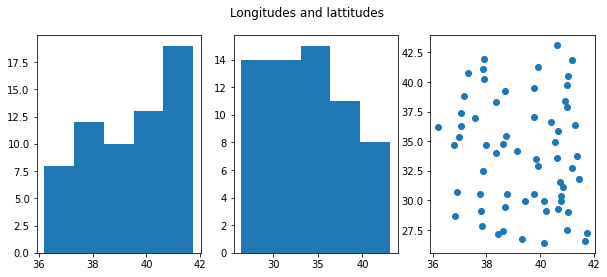

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

lats = [
    item[1] for item in longitudes_lattitudes.values() if item[1] is not None
]

longitudes = [
    item[0] for item in longitudes_lattitudes.values() if item[0] is not None
]

N_BINS = 5
ax[0].hist(lats, bins=N_BINS)
ax[1].hist(longitudes, bins=N_BINS)
ax[2].scatter(lats, longitudes)

fig.suptitle('Longitudes and lattitudes')

pep8(_ih)

#### Adding longitude and lattitude features

In [15]:
def add_longitude(city):
    val = longitudes_lattitudes.get(city, None)
    if val is not None:
        return val[0]


def add_lattitude(city):
    pair = longitudes_lattitudes.get(city, None)
    if pair is not None:
        return pair[1]


exploration_df['longitude'] = exploration_df['City'].apply(
    lambda city: add_longitude(city)
)

exploration_df['lattitude'] = exploration_df['City'].apply(
    lambda city: add_lattitude(city)
)

pep8(_ih)

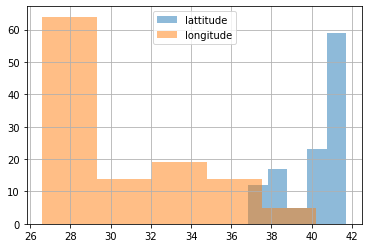

In [16]:
exploration_df['lattitude'].hist(bins=5, alpha=0.5, label='lattitude')
exploration_df['longitude'].hist(bins=5, alpha=0.5, label='longitude')
plt.legend()

#### Binning

In [17]:
exploration_df['lattitude_binned'] = pd.cut(
    exploration_df['lattitude'],
    bins=5,
    labels=[1, 2, 3, 4, 5]
).astype('int64')

exploration_df['longitude_binned'] = pd.cut(
    exploration_df['longitude'],
    bins=5,
    labels=[1, 2, 3, 4, 5]
).astype('int64')

pep8(_ih)

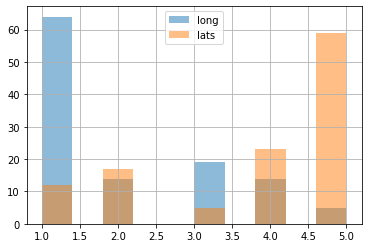

In [18]:
exploration_df['longitude_binned'].hist(alpha=0.5, label='long')
exploration_df['lattitude_binned'].hist(alpha=0.5, label='lats')
plt.legend()

In [19]:
# Now we need to transfer it into one-hot vectors
get_correlated_attributes(exploration_df, 'revenue', 0.1)

revenue             1.000000
P2                  0.191189
lattitude_binned    0.159036
lattitude           0.151199
P28                 0.150818
P6                  0.136381
P17                 0.133384
P13                -0.126957
P29                -0.127254
longitude          -0.195660
longitude_binned   -0.243286
Name: revenue, dtype: float64

In [20]:
from sklearn.preprocessing import OneHotEncoder

lattitude_encoder = OneHotEncoder()
longitude_encoder = OneHotEncoder()

lattitude_encoder.fit(exploration_df[['lattitude_binned']])
longitude_encoder.fit(exploration_df[['longitude_binned']])


pep8(_ih)

In [21]:
lats_bins_one_hot = lattitude_encoder.fit_transform(
    exploration_df[['lattitude_binned']]
).toarray()

longs_bins_one_hot = longitude_encoder.fit_transform(
    exploration_df[['longitude_binned']]
).toarray()

In [22]:
lats_bins_one_hot.shape

(116, 5)

In [23]:
print(lats_bins_one_hot[:3])
print(longs_bins_one_hot[:3])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


#### Feature crossing one-hot vectors

In [24]:
feature_crosses = np.array(
    [
        np.outer(lat_onehot, long_onehot).flatten()
        for lat_onehot, long_onehot in
        zip(lats_bins_one_hot, longs_bins_one_hot)
    ]
)

pep8(_ih)

In [25]:
print(feature_crosses.shape)
feature_crosses[:, 0].shape

(116, 25)


(116,)

In [26]:
for i in range(feature_crosses.shape[1]):
    exploration_df[f'cross_{i}'] = feature_crosses[:, i]

In [27]:
get_correlated_attributes(exploration_df, 'revenue', 0.09)

revenue             1.000000
cross_20            0.328622
P2                  0.191189
lattitude_binned    0.159036
lattitude           0.151199
P28                 0.150818
P6                  0.136381
P17                 0.133384
P22                 0.099139
P21                 0.094685
cross_23           -0.102220
P13                -0.126957
P29                -0.127254
cross_17           -0.171979
longitude          -0.195660
longitude_binned   -0.243286
Name: revenue, dtype: float64

In [28]:
exploration_df.columns

Index(['Open Date', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4', 'P5',
       'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16',
       'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26',
       'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36',
       'P37', 'revenue', 'longitude', 'lattitude', 'lattitude_binned',
       'longitude_binned', 'cross_0', 'cross_1', 'cross_2', 'cross_3',
       'cross_4', 'cross_5', 'cross_6', 'cross_7', 'cross_8', 'cross_9',
       'cross_10', 'cross_11', 'cross_12', 'cross_13', 'cross_14', 'cross_15',
       'cross_16', 'cross_17', 'cross_18', 'cross_19', 'cross_20', 'cross_21',
       'cross_22', 'cross_23', 'cross_24'],
      dtype='object')

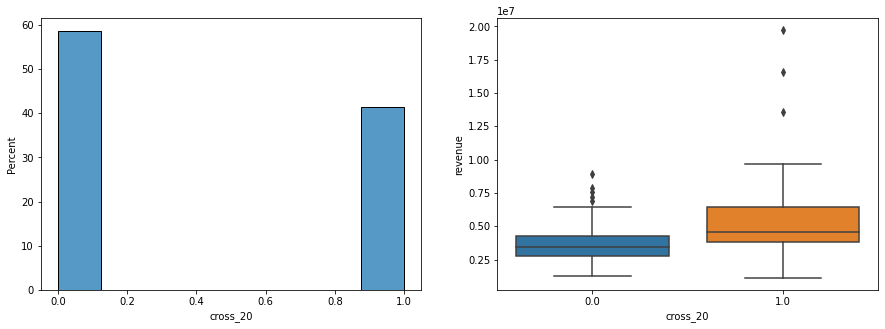

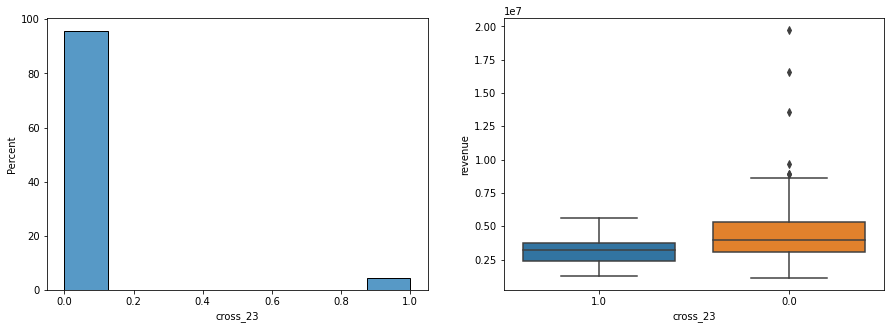

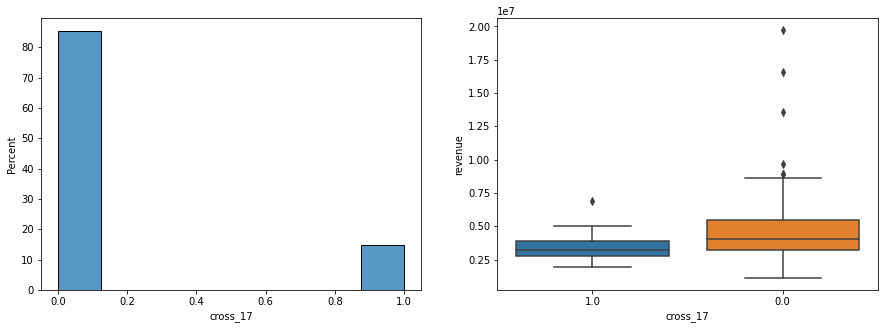

In [29]:
from sklearn_utils import boxplot_regression

boxplot_regression(exploration_df, 'cross_20', 'revenue')
boxplot_regression(exploration_df, 'cross_23', 'revenue')
boxplot_regression(exploration_df, 'cross_17', 'revenue')

### Population

In [ ]:
def write_population(city):
    populations = {
        'Gaziantep': 2069000,
        'Ankara': 5663000,
        'İstanbul': 15460000,
        'İzmir'  : 4367000,
        'Kocaeli'  : 2033441,
        'Osmaniye'  : 219339,
        'Kastamonu'  : 128537,
        'Eskişehir'  : 887475,
        'Denizli'  : 1028000,
        'Balıkesir'  : 1229000,
        'Sakarya'  : 567000,
        'Tekirdağ'  : 204001,
        'Bursa'  : 2055000,
        'Kayseri'  : 1062000,
        'Muğla'  : 1000773,
        'Edirne'  : 165979,
        'Samsun'  : 605319,
        'Karabük'  : 248014,
        'Adana'  : 1769000,
        'Afyonkarahisar'  : 744179,
        'Tokat'  : 612646,
        'Amasya'  : 91874,
        'Diyarbakır'   : 1783000,
        'Kütahya'  : 248054,
        'Antalya'   : 1319000,
        'Aydın'   : 1134031,
        'Şanlıurfa'  : 2031000,
        'Kırklareli'  : 88956,
        'Isparta'   : 198385,
        'Uşak'  :  500000,
        'Elazığ'  : 541258
    }
    
    
    assert city in populations.keys()
    return populations[city]

exploration_df['population'] = exploration_df['City'].apply(
    lambda row: write_population(row))

In [ ]:
get_correlated_attributes(exploration_df, 'revenue', 0.12)

revenue             1.000000
population          0.363098
cross_20            0.328622
BusinessPeriod      0.320551
P2                  0.191189
lattitude_binned    0.159036
lattitude           0.151199
P28                 0.150818
P6                  0.136381
P17                 0.133384
P13                -0.126957
P29                -0.127254
cross_17           -0.171979
longitude          -0.195660
longitude_binned   -0.243286
open_year          -0.318152
Name: revenue, dtype: float64

,BusinessPeriod,open_year
BusinessPeriod,1.000000,-0.997234
open_year,-0.997234,1.000000


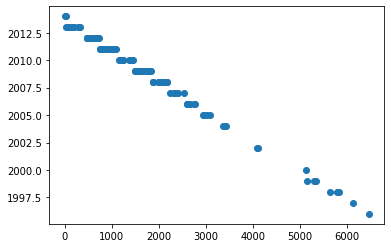

In [ ]:
plt.scatter(
    exploration_df['BusinessPeriod'],
    exploration_df['open_year']
)
exploration_df.loc[:, ['BusinessPeriod', 'open_year']].corr()

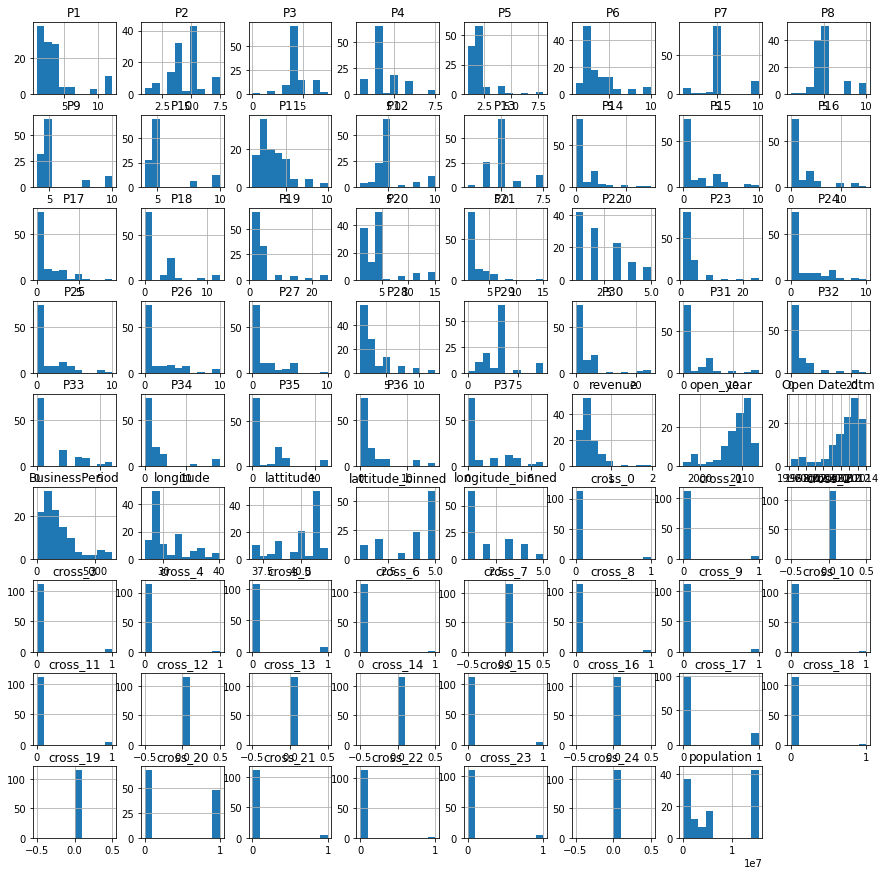

In [ ]:
_ = exploration_df.hist(figsize=(15, 15))

### City area

In [ ]:
def write_area(city):
    # in km2
    # urban area
    areas = {
        'Gaziantep': 6819,
        'Ankara': 2516,
        'İstanbul': 5343,
        'İzmir': 3159,
        'Kocaeli': 3626,
        'Osmaniye': 746,
        'Kastamonu': 1834,
        'Eskişehir': 2678,
        'Denizli': 798,
        'Balıkesir': 1453.97,
        'Sakarya': 4821,
        'Tekirdağ': 1111.53,
        'Bursa': 1036,
        'Kayseri': 6430,
        'Muğla': 1582,
        'Edirne': 844,
        'Samsun': 1055,
        'Karabük': 760,
        'Adana': 2280,
        'Afyonkarahisar': 14.23,
        'Tokat': 9.958,
        'Amasya': 1729.69,
        'Diyarbakır': 15355,
        'Kütahya': 2484.16,
        'Antalya': 1417,
        'Aydın': 627.2,
        'Şanlıurfa': 18584,
        'Kırklareli': 6550,
        'Isparta': 8993,
        'Uşak':  5341,
        'Elazığ': 2211.07,
            
        'Bolu': 1524.37,
        'Konya': 6600,
        'Trabzon': 188.85,
        'Niğde': 2302.99,
        'Aksaray': 4589,
        'Artvin': 1084.74,
        'Batman': 563.59,
        'Bilecik': 840.47,
        'Düzce': 739.13,
        'Erzincan': 1622.08,
        'Erzurum': None,
        'Giresun': 317,
        'Hatay': 5524,
        'Kahramanmaraş': None,
        'Kars': 1804,
        'Kırıkkale': 318.07,
        'Kırşehir': 1677.67,
        'Malatya': 822.16,
        'Manisa': 13339,
        'Mardin': 8891,
        'Mersin': 1590,
        'Nevşehir': 535,
        'Ordu': 586,
        'Rize': 250.14,
        'Siirt': 284,
        'Sivas': 2768,
        'Tanımsız': None,  # ??? not in google
        'Yalova': 166.85,
        'Zonguldak': 632.98,
        'Çanakkale': 937.82,
        'Çankırı': 1347.05,
        'Çorum': 2276.81
    }
    
    assert city in areas.keys()
    return areas[city]


In [ ]:
# exploration_df['population'] = exploration_df['City'].apply(
#     lambda row: write_population(row))

exploration_df['City area'] = exploration_df['City'].apply(
    lambda row: write_area(row)
)

revenue             1.000000
population          0.363098
cross_20            0.328622
BusinessPeriod      0.320551
P2                  0.191189
lattitude_binned    0.159036
lattitude           0.151199
P28                 0.150818
P6                  0.136381
P17                 0.133384
City area           0.122537
P22                 0.099139
P21                 0.094685
cross_23           -0.102220
P13                -0.126957
P29                -0.127254
cross_17           -0.171979
longitude          -0.195660
longitude_binned   -0.243286
open_year          -0.318152
Name: revenue, dtype: float64


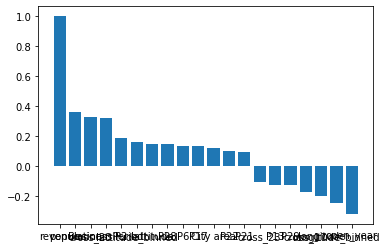

In [ ]:
corr_series = get_correlated_attributes(exploration_df, 'revenue', 0.09)
plt.bar(
    # np.arange(len(corr_series.values)), 
    corr_series.index,
    corr_series.values
)
print(corr_series)

# 7. Data preparation

## Check missing and infinite values

In [118]:
nan_statistics(train_val_sample), nan_statistics(test_sample)

Col -- Nan percentage
Col -- Nan percentage


({}, {})

## Text and categorical attributes

In [119]:
def get_categorical_columns(df_):
    return df_.dtypes[df_.dtypes == 'object']

cat_columns = get_categorical_columns(train_val_sample)
cat_columns

Open Date     object
City          object
City Group    object
Type          object
dtype: object

In [120]:
train_val_sample['City Group'].value_counts()

Big Cities    67
Other         49
Name: City Group, dtype: int64

### City Group


In [121]:
# Apply ordinal encoding. 
# Such that big cities were ranked higher, than other
# areas.

enc = OrdinalEncoder(categories = [['Other', 'Big Cities']])
enc.fit(train_val_sample[['City Group']])

OrdinalEncoder(categories=[['Other', 'Big Cities']])

### Type (of restaurant)

In [122]:
one_hot_enc = OneHotEncoder()
one_hot_enc.fit(train_val_sample[['Type']])

OneHotEncoder()

In [123]:
res = one_hot_enc.transform(train_val_sample[['Type']])
res

<116x3 sparse matrix of type '<class 'numpy.float64'>'
	with 116 stored elements in Compressed Sparse Row format>

### City 

- Dropping that column

In [124]:
dropper = ColumnDropper(
    columns_to_drop = ['City']
)

res = dropper.fit_transform(train_val_sample)
assert not 'City' in res.columns
assert 'City' in train_val_sample.columns

# Engineer new features

### Area, population, opening year

In [150]:
from sklearn.base import TransformerMixin, BaseEstimator


class PopulationAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.populations = {
            'Gaziantep': 2069000,
            'Ankara': 5663000,
            'İstanbul': 15460000,
            'İzmir': 4367000,
            'Kocaeli': 2033441,
            'Osmaniye': 219339,
            'Kastamonu': 128537,
            'Eskişehir': 887475,
            'Denizli': 1028000,
            'Balıkesir': 1229000,
            'Sakarya': 567000,
            'Tekirdağ': 204001,
            'Bursa': 2055000,
            'Kayseri': 1062000,
            'Muğla': 1000773,
            'Edirne': 165979,
            'Samsun': 605319,
            'Karabük': 248014,
            'Adana': 1769000,
            'Afyonkarahisar': 744179,
            'Tokat': 612646,
            'Amasya': 91874,
            'Diyarbakır': 1783000,
            'Kütahya': 248054,
            'Antalya': 1319000,
            'Aydın': 1134031,
            'Şanlıurfa': 2031000,
            'Kırklareli': 88956,
            'Isparta': 198385,
            'Uşak':  500000,
            'Elazığ': 541258,
            'Bolu': 131264,
            'Konya': 2161000,
            'Trabzon': 312060,
            'Niğde': 341412,
            'Aksaray': 416317,
            'Artvin': 25771,
            'Batman': 348963,
            'Bilecik': 64531,
            'Düzce': 135557,
            'Erzincan': 236034,
            'Erzurum': 767848,
            'Giresun': 100712,
            'Hatay': 1670712,
            'Kahramanmaraş': 547000,
            'Kars': 78100,
            'Kırıkkale': 192473,
            'Kırşehir': 114244,
            'Malatya': 512000,
            'Manisa': 356702,
            'Mardin': 809719,
            'Mersin': 955106,
            'Nevşehir': 303010,
            'Ordu': 229214,
            'Rize': 344359,
            'Siirt': 135350,
            'Sivas': 359219,
            'Tanımsız': 500000,  # ??? not in google
            'Yalova': 121479,
            'Zonguldak': 213544,
            'Çanakkale': 328736,
            'Çankırı': 216362,
            'Çorum': 237000
        }
        self.max_population = np.max(list(self.populations.values()))
        self.min_population = np.min(list(self.populations.values()))

    def fit(self, X, y=None):
        return self

    def write_population(self, city):
        assert city in self.populations.keys(), print(city)

        return self.populations[city]

        # return (self.populations[city] - self.min_population)\
        #     / (self.max_population - self.min_population)

    def transform(self, X, y=None):
        transformed_df = X.copy()
        transformed_df['population'] = X['City'].apply(
            lambda row: self.write_population(row)
        )
        return transformed_df


pep8(_ih)

In [151]:
from sklearn.base import BaseEstimator, TransformerMixin

class AreaAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.areas = {
            'Gaziantep': 6819,
            'Ankara': 2516,
            'İstanbul': 5343,
            'İzmir': 3159,
            'Kocaeli': 3626,
            'Osmaniye': 746,
            'Kastamonu': 1834,
            'Eskişehir': 2678,
            'Denizli': 798,
            'Balıkesir': 1453.97,
            'Sakarya': 4821,
            'Tekirdağ': 1111.53,
            'Bursa': 1036,
            'Kayseri': 6430,
            'Muğla': 1582,
            'Edirne': 844,
            'Samsun': 1055,
            'Karabük': 760,
            'Adana': 2280,
            'Afyonkarahisar': 14.23,
            'Tokat': 9.958,
            'Amasya': 1729.69,
            'Diyarbakır': 15355,
            'Kütahya': 2484.16,
            'Antalya': 1417,
            'Aydın': 627.2,
            'Şanlıurfa': 18584,
            'Kırklareli': 6550,
            'Isparta': 8993,
            'Uşak':  5341,
            'Elazığ': 2211.07,

            'Bolu': 1524.37,
            'Konya': 6600,
            'Trabzon': 188.85,
            'Niğde': 2302.99,
            'Aksaray': 4589,
            'Artvin': 1084.74,
            'Batman': 563.59,
            'Bilecik': 840.47,
            'Düzce': 739.13,
            'Erzincan': 1622.08,
            'Erzurum': None,
            'Giresun': 317,
            'Hatay': 5524,
            'Kahramanmaraş': None,
            'Kars': 1804,
            'Kırıkkale': 318.07,
            'Kırşehir': 1677.67,
            'Malatya': 822.16,
            'Manisa': 13339,
            'Mardin': 8891,
            'Mersin': 1590,
            'Nevşehir': 535,
            'Ordu': 586,
            'Rize': 250.14,
            'Siirt': 284,
            'Sivas': 2768,
            'Tanımsız': None,  # ??? not in google
            'Yalova': 166.85,
            'Zonguldak': 632.98,
            'Çanakkale': 937.82,
            'Çankırı': 1347.05,
            'Çorum': 2276.81
        }
        self.mean_area = np.mean([area for area in self.areas.values() if \
                                  area is not None])
    
    def fit(self, X, y=None):
        return self
    
    def assign_area(self, city):
        assert city in self.areas.keys()
        
        if self.areas[city] is None:
            return self.mean_area
        else:
            return self.areas[city]

    def transform(self, X, y=None):
        transformed_df = X.copy()
        transformed_df['city_area'] = transformed_df['City'].apply(
            lambda city: self.assign_area(city)
        )
        return transformed_df

In [152]:
from sklearn.base import BaseEstimator, TransformerMixin


class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self._column_index = 0  # column_index

    def fit(self, X, y=None):
        return self

    def get_year(self, date_):
        return int(date_.split('/')[-1])

    def transform(self, X, y=None):
        dates = X.loc[:, 'Open Date'].values
        numeric_years = np.array(
            list(map(self.get_year, dates)), dtype=np.float64
        )

        res_df = X.copy()
        res_df['Open Date'] = (numeric_years)
        # X[:, self._column_index] = res
        return res_df


pep8(_ih)

In [153]:
from sklearn.base import TransformerMixin, BaseEstimator


class HugeAreaAndPopulationAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.copy()

        X_transformed['huge_population'] = np.array(
            X_transformed['population'] > 1e7,
            dtype=np.int64
        )

        X_transformed['huge_city_area'] = np.array(
            X_transformed['city_area'] > 10000,
            dtype=np.int64
        )

        return X_transformed

In [154]:
transformers = [
    AreaAdder(),
    PopulationAdder(),
    DateTransformer(),
    HugeAreaAndPopulationAdder()
]


for t in transformers:
    train_val_sample = t.fit_transform(train_val_sample)
    test_sample = t.transform(test_sample)
    test_df = t.transform(test_df)

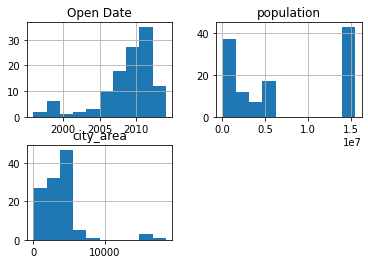

In [155]:
_ = train_val_sample[['Open Date', 'population', 'city_area']].hist()

In [156]:
get_correlated_attributes(train_val_sample, 'revenue', 0.12)

revenue            1.000000
huge_population    0.372979
population         0.363098
P2                 0.191189
P28                0.150818
P6                 0.136381
P17                0.133384
city_area          0.122537
P13               -0.126957
P29               -0.127254
Open Date         -0.318152
Name: revenue, dtype: float64

### Engineer longitudes, lattitudes and feature crosses

In [189]:
from sklearn.base import TransformerMixin, BaseEstimator


class LongitudeLattitudeAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

        # Longitude, lattitude
        self.longitudes_lattitudes = {
            'Gaziantep': [37.383331, 37.066666],
            'Ankara': [32.866287, 39.925533],
            'İstanbul': [28.979530, 41.015137],
            'İzmir': [27.142826, 38.423733],
            'Kocaeli': [29.916668, 40.766666],
            'Osmaniye': [36.246400, 37.074628],
            'Kastamonu': [33.77528, 41.376625],
            'Eskişehir': [30.526714, 39.766193],
            'Denizli': [29.094715, 37.783333],
            'Balıkesir': [26.726990, 39.327923],
            'Sakarya': [30.400000, 40.783333],
            'Tekirdağ': [27.515278, 40.977779],
            'Bursa': [29.074202, 40.193298],
            'Kayseri': [35.467987, 38.734802],
            'Muğla': [28.643204, 36.834740],
            'Edirne': [26.583481, 41.674965],
            'Samsun': [36.336067, 41.2867],
            'Karabük': [32.741742, 41.187489],
            'Adana': [35.321335, 37.000000],
            'Afyonkarahisar': [30.538704, 38.756886],
            'Tokat': [36.625186, 40.390271],
            'Amasya': [35.828819, 40.652382],
            'Diyarbakır': [40.240002, 37.910000],
            'Kütahya': [29.985732, 39.419955],
            'Antalya': [30.6833, 36.9],
            'Aydın': [27.845560, 37.838016],
            'Şanlıurfa': [38.791668, 37.158333],
            'Kırklareli': [27.224369, 41.735472],
            'Isparta': [30.553705, 37.762649],
            'Uşak':  [29.405882, 38.674229],
            'Elazığ': [39.226398, 38.680969],

            'Bolu': [31.589813, 40.731647],
            'Konya': [32.493156, 37.874641],
            'Trabzon': [39.716763, 41.002697],
            'Niğde': [34.676608, 37.969774],
            'Aksaray': [34.029700, 38.368626],
            'Artvin': [41.830982, 41.183224],
            'Batman': [41.12793, 37.88289],
            'Bilecik': [29.979330, 40.142573],
            'Düzce': [31.162609, 40.838720],
            'Erzincan': [39.491124, 39.746797],
            'Erzurum': [41.265824, 39.905499],
            'Giresun': [38.392654, 40.917534],
            'Hatay': [36.166668, 36.200001],
            'Kahramanmaraş': [36.922821, 37.575275],
            'Kars': [43.097453, 40.601338],
            'Kırıkkale': [33.508878, 39.839784],
            'Kırşehir': [34.159499, 39.146078],
            'Malatya': [38.333525, 38.355363],
            'Manisa': [27.422222, 38.630554],
            'Mardin': [40.733951, 37.312903],
            'Mersin': [34.641479, 36.812103],
            'Nevşehir': [34.719975, 38.626995],
            'Ordu': [37.879721, 40.986166],
            'Rize': [40.517666, 41.025511],
            'Siirt': [41.941978, 37.927404],
            'Sivas': [37.015598, 39.750359],
            'Tanımsız': [None, None],  # ??? not in google
            'Yalova': [29.284186, 40.654895],
            'Zonguldak': [31.791344, 41.451733],
            'Çanakkale': [26.408587, 40.146720],
            'Çankırı': [33.616223, 40.600207],
            'Çorum': [34.953724, 40.549926]
        }

    def fit(self, X, y=None):
        return self

    def _add_longitude_or_lattitude(self, city, what_to_add):
        assert what_to_add in ['longitude', 'lattitude']
        INDEX = None
        if what_to_add == 'longitude':
            INDEX = 0
        else:
            INDEX = 1

        val_pair = self.longitudes_lattitudes.get(city, None)
        if val_pair[INDEX] is not None:
            return val_pair[INDEX]
        else:
            return np.mean(
                [val_pair[INDEX]
                 for val_pair in self.longitudes_lattitudes.values()
                 if val_pair[INDEX] is not None
                 ]
            )

    def add_longitude(self, city):
        return self._add_longitude_or_lattitude(city, what_to_add='longitude')

    def add_lattitude(self, city):
        return self._add_longitude_or_lattitude(city, what_to_add='lattitude')

    def transform(self, X, y=None):
        df_transformed = X.copy()

        df_transformed['longitude'] = X['City'].apply(
            lambda city: self.add_longitude(city)
        )

        df_transformed['lattitude'] = X['City'].apply(
            lambda city: self.add_lattitude(city)
        )

        return df_transformed


pep8(_ih)

In [190]:
transformers = [
    LongitudeLattitudeAdder()
]

for t in transformers:
    train_val_sample = t.fit_transform(train_val_sample)
    test_sample = t.transform(test_sample)
    test_df = t.transform(test_df)

In [238]:
from pandas.io.formats.style_render import non_reducing_slice
from sklearn.base import BaseEstimator, TransformerMixin


class LongitudeLattitudeBinner(BaseEstimator, TransformerMixin):
    def __init__(self, n_lattitude_bins_, n_longitude_bins_):
        super().__init__()
        self.n_lattitude_bins = n_lattitude_bins_
        self.n_longitude_bins = n_longitude_bins_

        self.lattitude_labels = [i for i in range(self.n_lattitude_bins)]
        self.longitude_labels = [i for i in range(self.n_longitude_bins)]

        self.lattitude_bins = None
        self.longitude_bins = None

    def _get_bins(self, column_name_, df_):
        if column_name_ == 'lattitude':
            n_bins = self.n_lattitude_bins
            labels = self.lattitude_labels
        elif column_name_ == 'longitude':
            n_bins = self.n_longitude_bins
            labels = self.longitude_labels

        _, bins = pd.cut(
            df_[column_name_],
            bins=n_bins,
            labels=labels,
            retbins=True
        )
        return bins

    def fit(self, X, y=None):
        transformed_df = X.copy()
        self.lattitude_bins = self._get_bins('lattitude', transformed_df)
        self.longitude_bins = self._get_bins('longitude', transformed_df)
        print(self.lattitude_bins, self.longitude_bins)
        return self

    def _get_binned_column(self, df_, column_name_):
        assert column_name_ in ['lattitude', 'longitude']
        if column_name_ == 'lattitude':
            bins = self.lattitude_bins
            labels = self.lattitude_labels
        elif column_name_ == 'longitude':
            bins = self.longitude_bins
            labels = self.longitude_labels

        binned_col = pd.cut(
            x=df_[column_name_],
            bins=bins,
            labels=labels
        )
        binned_col = binned_col.cat.codes
        return binned_col

    def transform(self, X, y=None):
        transformed_df = X.copy()

        transformed_df['lattitude_binned'] = self._get_binned_column(
            df_=transformed_df,
            column_name_='lattitude'
        )

        transformed_df['longitude_binned'] = self._get_binned_column(
            df_=transformed_df,
            column_name_='longitude'
        )
        return transformed_df


pep8(_ih)

In [245]:
class LongitudeLattitudeCrosser(TransformerMixin, BaseEstimator):
    def __init__(self, lat_categories_, long_categories_):
        super().__init__()
        self.lat_categories = lat_categories_
        self.long_categories = long_categories_
        # self.lattitude_categories = lattitude_categories_
        # self.longitude_categories = longitude_categories_

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        transformed_df = X.copy()

        lattitude_encoder = OneHotEncoder(
            categories=[self.lat_categories]
        )
        longitude_encoder = OneHotEncoder(
            categories=[self.long_categories]
        )

        lattitude_binned_onehot = lattitude_encoder.fit_transform(
            transformed_df[['lattitude_binned']]
        ).toarray()

        longitude_binned_onehot = longitude_encoder.fit_transform(
            transformed_df[['longitude_binned']]
        ).toarray()

        crossed_features = np.array(
            [
                np.outer(lat_onehot, long_onehot).flatten()
                for lat_onehot, long_onehot in
                zip(lattitude_binned_onehot, longitude_binned_onehot)
            ]
        )

        for i in range(crossed_features.shape[1]):
            transformed_df[f'cross_{i}'] = crossed_features[:, i]

        return transformed_df


pep8(_ih)

In [246]:
a = np.sort(test_df['lattitude_binned'].unique()) # .values.sort()
print(a)

[-1  0  1  2  3  4]


In [265]:
long_lat_binner = LongitudeLattitudeBinner(
    n_lattitude_bins_=5,
    n_longitude_bins_=5
)

long_lat_crosser = LongitudeLattitudeCrosser(
    lat_categories_ = [-1, 0, 1, 2, 3, 4],
    long_categories_ = [-1, 0, 1, 2, 3, 4]
    # lattitude_categories_ = long_lat_binner.lattitude_labels,
    # longitude_categories_ = long_lat_binner.longitude_labels
)

transformers = [
    long_lat_binner,
    long_lat_crosser
    # LongitudeLattitudeCrosser()
]


for t in transformers:
    train_val_sample = t.fit_transform(train_val_sample)
    test_sample = t.transform(test_sample)
    test_df = t.transform(test_df)

    assert train_val_sample.isna().sum().sum() == 0
    assert test_sample.isna().sum().sum() == 0
    assert test_df.isna().sum().sum() == 0, print(test_df.isna().sum().sum())
    assert \
    len(train_val_sample.columns) \
    == len(test_sample.columns) \
    == len(test_df.columns) + 1

[36.82983927 37.8148864  38.7950328  39.7751792  40.7553256  41.735472  ] [26.56982448 29.3147852  32.0460894  34.7773936  37.5086978  40.240002  ]


# Define columns for pipeline

In [ ]:
assert (train_val_sample.columns == test_sample.columns).all()

num_cols = train_val_sample.columns[
    np.isin(train_val_sample.dtypes, ['float64', 'int64'])
]

num_cols = num_cols.drop('revenue')

cat_cols = train_val_sample.columns[
    train_val_sample.dtypes == 'object'
]

target_cols = ['revenue']

print(cat_cols)
print(num_cols)
print(target_cols)

ValueError: ignored

## Creating pipeline

In [ ]:
num_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', MinMaxScaler())
    ]
)

city_group_pipeline = Pipeline(
    [
        ('encoder', OrdinalEncoder(categories=[['Other', 'Big Cities']]))  
    ]
)

type_pipeline = Pipeline(
    [
        ('encoder', OneHotEncoder(categories=[['IL', 'FC', 'DT', 'MB']]))
    ]
)

city_pipeline = Pipeline(
    [
        ('drop', ColumnDropper(['City']))
    ]
)



In [ ]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [
        ('numeric_data', num_pipeline, num_cols),
        ('city_group', city_group_pipeline, ['City Group']),
        ('type', type_pipeline, ['Type']),
        ('drop', city_pipeline, ['City'])
    ],
    remainder='passthrough'
)

In [ ]:
# These are the subsets of the training set
trainval_sample_processed = preprocessor.fit_transform(
    train_val_sample
)
test_sample_processed = preprocessor.transform(test_sample)

In [ ]:
# This is the kaggle test set
test_df['revenue'] = np.ones(test_df.shape[0]) # to avoid bug. because no such column
test_processed = preprocessor.transform(
    test_df
)

In [ ]:
trainval_sample_processed.dtype

dtype('float64')

## Log transform to target

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X[:, -1] = np.log(X[:, -1])
        return X

log_transformer = LogTransformer()

trainval_sample_processed = log_transformer.fit_transform(
    trainval_sample_processed
)

In [ ]:
test_sample_processed = log_transformer.transform(
    test_sample_processed
)

In [ ]:
test_processed = log_transformer.transform(
    test_processed
)

# Drop unnecessary columns

In [ ]:
# Already dropped in the 'drop' step above

array(['1', '2', '3.0', 'abc'], dtype='<U32')

# Saving processed data

In [ ]:
manager.save_to_csv(
    array_=trainval_sample_processed,
    path_=manager.data_trial_path,
    file_name_='trainval_sample_processed.csv'
)

In [ ]:
manager.save_to_csv(
    array_=test_sample_processed,
    path_=manager.data_trial_path,
    file_name_='test_sample_processed.csv'
)

In [ ]:
manager.save_to_csv(
    array_=test_processed,
    path_=manager.data_trial_path,
    file_name_='test_processed.csv'
)

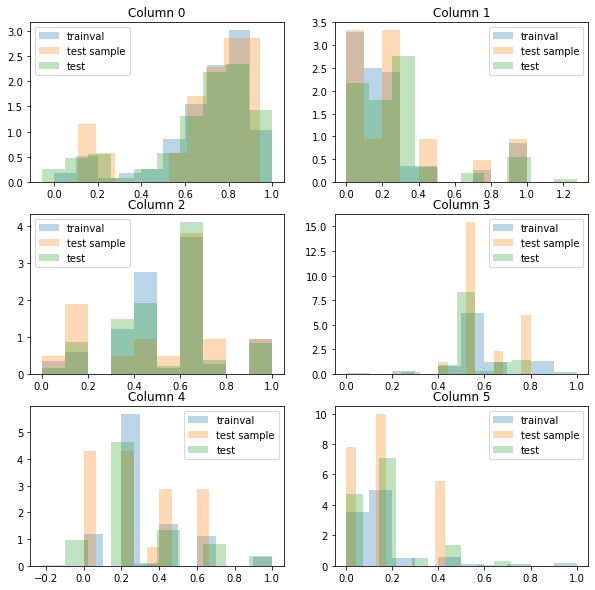

In [ ]:
visualize_datasets_distributions(
    {
        'trainval': pd.DataFrame(trainval_sample_processed),
        'test sample': pd.DataFrame(test_sample_processed),
        'test': pd.DataFrame(test_processed)
    },
    column_numbers_ = range(5),
    grid_width_=2
)